In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [21]:
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.utils as vutils
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import image as img
import matplotlib.animation as animation
from IPython.display import HTML

In [23]:
train_path = 'C:/Users/Gaurav/Downloads/rendered_chairs/'

In [24]:
print(len(os.listdir(train_path)))
print(os.listdir(train_path))
print(os.listdir(train_path))

1
['MajorProject']
['MajorProject']


In [70]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers


# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
train_ds = ImageFolder(train_path, transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [27]:
print('Total number of images:', len(train_ds))
image, label = train_ds[7500]
print(image.shape)
print('Label:', label)
print(image[:, 30:35, 30:35])
torch.min(image), torch.max(image)

Total number of images: 11048
torch.Size([3, 64, 64])
Label: 0
tensor([[[ 1.0000,  0.9843,  0.9059,  0.1686, -0.3882],
         [ 0.9059,  0.8980,  0.7647, -0.0588, -0.3647],
         [-0.0275, -0.0275, -0.0902, -0.3176, -0.3882],
         [-0.4588, -0.4667, -0.4588, -0.3569, -0.3255],
         [ 0.1137,  0.1137, -0.1608, -0.4275, -0.3647]],

        [[ 1.0000,  1.0000,  0.9529,  0.0353, -0.6941],
         [ 0.8745,  0.8745,  0.7804, -0.2078, -0.6941],
         [-0.2549, -0.2471, -0.2392, -0.5765, -0.7412],
         [-0.6706, -0.6706, -0.6157, -0.6235, -0.6863],
         [-0.0196, -0.0118, -0.3020, -0.6863, -0.7255]],

        [[ 1.0000,  1.0000,  0.9608, -0.0353, -0.8431],
         [ 0.8510,  0.8588,  0.7725, -0.2863, -0.8510],
         [-0.3725, -0.3569, -0.3176, -0.6863, -0.8824],
         [-0.7725, -0.7569, -0.7020, -0.7412, -0.8275],
         [-0.0745, -0.0667, -0.3725, -0.7882, -0.8588]]])


(tensor(-0.9608), tensor(1.))

In [28]:
train_dl  = DataLoader(train_ds, batch_size, shuffle = True, num_workers = workers)

In [29]:
for images, labels in train_dl:
  print(images.shape)
  print(labels)
  break

torch.Size([100, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


#Weight Initialization 
The authors of the DCGAN paper specify that all model weights shall be randomly initialized from a normal distribution with mean = 0 and std = 0.02.
This function is applied immediatly after initialization.

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#Generator 
This module is designed to convert latent space vector z into a data-space bearing the same dimensions as our training data.
Its implementation is achieved through a series of strided 2D convolutional transpose layers each of which bearing a 2D batch norm layer and relu activation. The output of the generator is fed through the tanh function to return it to the input data range of [-1,1]

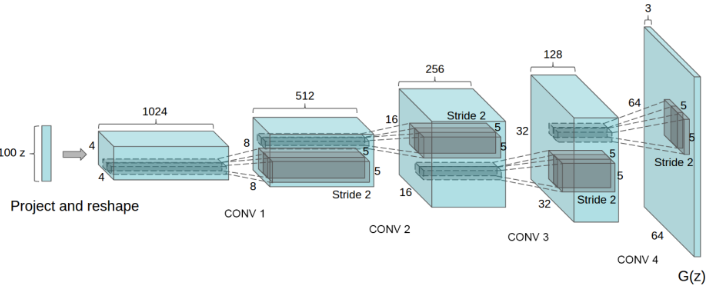

In [31]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is latent vector Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [32]:
y = Generator().to(device)
y.apply(weights_init)

gen_imgs = y(torch.randn(100, nz, 1, 1, device = device))

In [33]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

print(len(train_dl))

111


In [34]:
print(gen_imgs.shape)
print(gen_imgs[0].shape)
print(gen_imgs[0])

torch.Size([100, 3, 64, 64])
torch.Size([3, 64, 64])
tensor([[[ 0.1050,  0.0249,  0.1944,  ...,  0.0026,  0.0323, -0.0325],
         [-0.0867, -0.1374, -0.0792,  ..., -0.1443, -0.1024, -0.0336],
         [ 0.1502, -0.0608,  0.2191,  ..., -0.0869,  0.1713, -0.0559],
         ...,
         [-0.1516, -0.1842, -0.1653,  ..., -0.1859, -0.1102, -0.1185],
         [ 0.0862, -0.0260,  0.1338,  ..., -0.0661,  0.2357, -0.0500],
         [-0.0745, -0.1209, -0.0715,  ..., -0.0713, -0.0367, -0.0860]],

        [[-0.0113,  0.0278,  0.0196,  ...,  0.0176,  0.0415, -0.0642],
         [ 0.0749,  0.0529,  0.0805,  ...,  0.1871,  0.1568,  0.1193],
         [-0.0879,  0.0057, -0.0601,  ...,  0.0294,  0.0856, -0.0346],
         ...,
         [ 0.0802,  0.1690,  0.2429,  ...,  0.1205, -0.0176,  0.0992],
         [ 0.0171, -0.0008, -0.1120,  ..., -0.0058, -0.1259,  0.0709],
         [ 0.0094,  0.0409,  0.0416,  ..., -0.0084,  0.0261,  0.0309]],

        [[-0.0093, -0.0752,  0.0004,  ..., -0.0737,  0.0609, -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


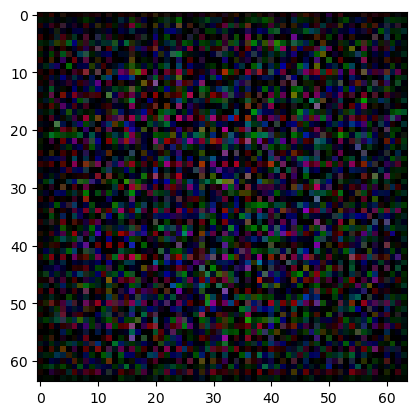

In [35]:
# displaying the normalized image

plt.imshow(gen_imgs[0].detach().cpu().permute(1,2,0))

In [36]:
from PIL import Image
norm_images = denorm(gen_imgs.detach().cpu())
print(norm_images.shape)
print(norm_images[0].shape)
print(norm_images[0])

torch.Size([100, 3, 64, 64])
torch.Size([3, 64, 64])
tensor([[[0.5525, 0.5125, 0.5972,  ..., 0.5013, 0.5161, 0.4838],
         [0.4566, 0.4313, 0.4604,  ..., 0.4278, 0.4488, 0.4832],
         [0.5751, 0.4696, 0.6095,  ..., 0.4566, 0.5856, 0.4720],
         ...,
         [0.4242, 0.4079, 0.4173,  ..., 0.4070, 0.4449, 0.4407],
         [0.5431, 0.4870, 0.5669,  ..., 0.4669, 0.6179, 0.4750],
         [0.4627, 0.4395, 0.4642,  ..., 0.4643, 0.4817, 0.4570]],

        [[0.4944, 0.5139, 0.5098,  ..., 0.5088, 0.5208, 0.4679],
         [0.5375, 0.5265, 0.5403,  ..., 0.5935, 0.5784, 0.5597],
         [0.4561, 0.5029, 0.4699,  ..., 0.5147, 0.5428, 0.4827],
         ...,
         [0.5401, 0.5845, 0.6215,  ..., 0.5603, 0.4912, 0.5496],
         [0.5086, 0.4996, 0.4440,  ..., 0.4971, 0.4370, 0.5354],
         [0.5047, 0.5205, 0.5208,  ..., 0.4958, 0.5130, 0.5154]],

        [[0.4953, 0.4624, 0.5002,  ..., 0.4632, 0.5305, 0.4770],
         [0.5106, 0.4798, 0.5247,  ..., 0.4938, 0.5158, 0.5134],
     

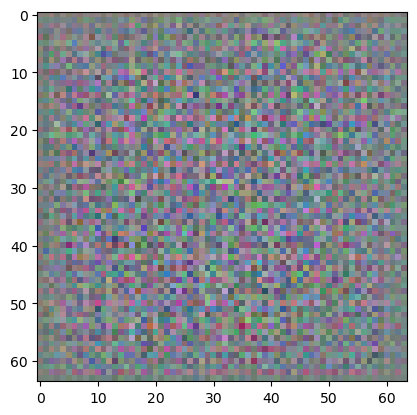

In [37]:
#displaying the de-normalized image

plt.imshow(norm_images[0].permute(1,2,0))

In [38]:
# creating the generator model 
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

#printing the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#Discriminator 


In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
    
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [40]:
# Create the Discriminator model.
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss functions and optimizers: 
We use Binary Cross Entropy Loss. 
We use adam optimizer. 


In [41]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) 

In [42]:
''' Training Functions'''

def reset_grad():
    optimizerD.zero_grad()
    optimizerG.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = netD(images).view(-1)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, nz).to(device)
    fake_images = netG(z)
    outputs = netD(fake_images).view(-1)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    optimizerD.step()
    
    return d_loss, real_score, fake_score

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, nz).to(device)
    fake_images = netG(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(netD(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optimizerG.step()
    return g_loss, fake_images

In [43]:
# this is where we save the intermediate outputs from the generator
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

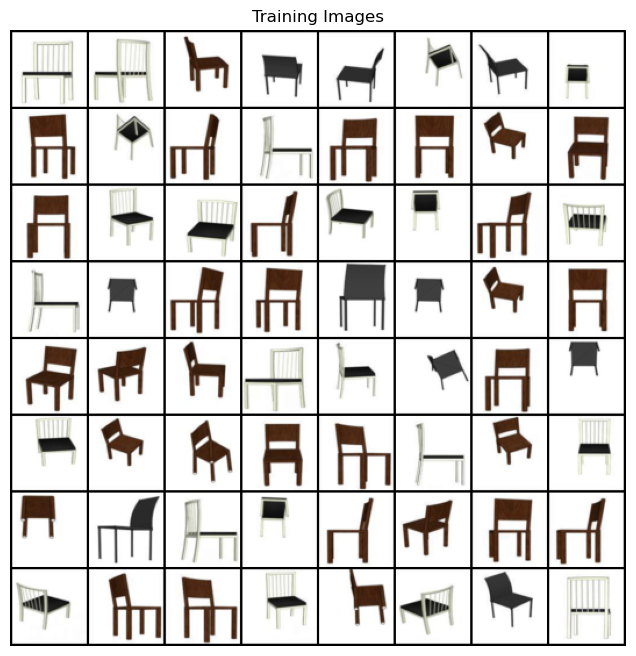

In [44]:

# Save some real images
real_batch = next(iter(train_dl))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.savefig('samples/real_images.png')




saved fake_images-0000.png


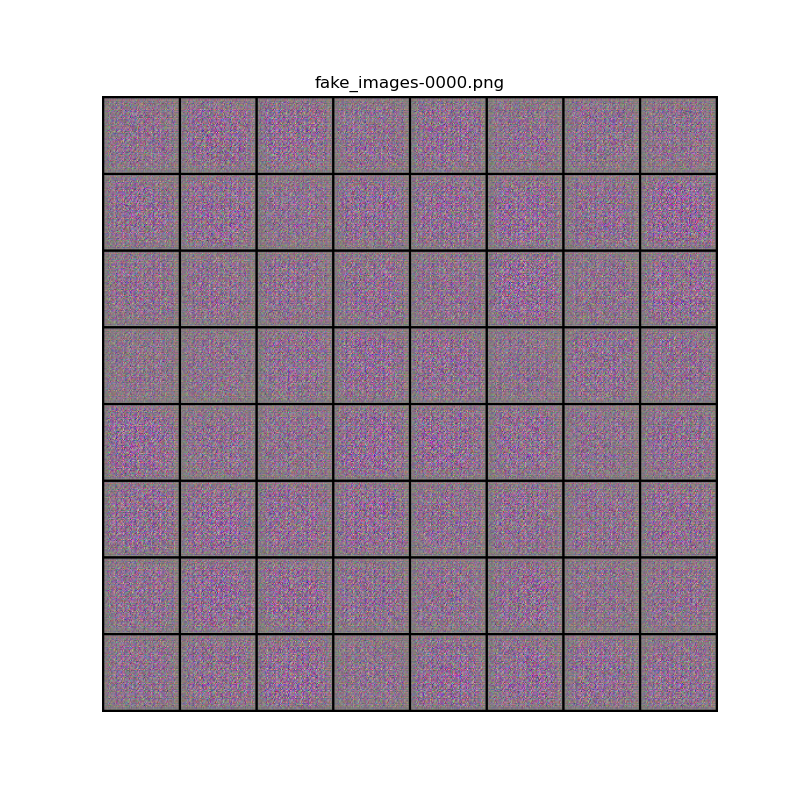

In [68]:
from IPython.display import Image
from torchvision.utils import save_image

def save_fake_images(index):
  fake_images = netG(fixed_noise)
  fake_name = 'fake_images-{0:0=4d}.png'.format(index)
  plt.figure(figsize = (8, 8))
  plt.axis("off")
  plt.title(fake_name)
  images = plt.imshow(np.transpose(vutils.make_grid(fake_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
  plt.savefig('samples/{}'.format(fake_name))
  print('saved', fake_name)
  plt.close()

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


Training the Discriminator:
The goal here is to maximize the probablity of correctly classified inputs as real or fake.

Training the Generator:
We want to train the generator such that we minimise the log(1-D(G(z)) so we generate better fakes.

In [93]:
test_criterion = nn.BCELoss()

testD = Discriminator().to(device)
testD.apply(weights_init)
testG = Generator().to(device)
testG.apply(weights_init)
lr = 0.00005
testOD = optim.Adam(testD.parameters(), lr=lr, betas=(beta1, 0.999))
testOG = optim.Adam(testG.parameters(), lr=lr, betas=(beta1, 0.999)) 

test_epoch = 3

print()

In [94]:
# for i, data in enumerate(train_dl, 0):
#     images = data[0].to(device)
#     b_size = images.size(0)
#     label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#     output = testD(images).view(-1)
#     print(b_size, label)
#     print(output)
#     break
# len(train_dl)

In [95]:
total_step = len(train_dl)
d_losses, g_losses = [], []
iters = 0

print("STARTING TRAINING LOOP....")

for epoch in range(test_epoch):
  for i, data in enumerate(train_dl, 0):
    ##############################################
    # Updating the Discriminator network. 
    # We aim to maximise the discriminator loss [log(D(x)) + log(1-log(D(G(z)))]
    #############################################
    ## training with the real batch
    testD.zero_grad()
    #format the batch
    images = data[0].to(device)
    b_size = images.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass the real batch through the discriminator
    output = testD(images).view(-1)
    # Calculate loss on the real batch
    errD_real = test_criterion(output, label)
    # Calculate the gradients for Disciminator in backward pass
    errD_real.backward()
    D_x = output.mean().item()
    
    ## training with the fake batch
    # Generate batch of latent vectors
    noise = torch.rand(b_size, nz, 1, 1, device = device)
    # Generate fake image batch.
    fake = testG(noise)
    label.fill_(fake_label)
    # Classify the fake batch with the discriminator
    output = testD(fake.detach()).view(-1)
    # Calculate the discriminator loss on the fake batch
    errD_fake = test_criterion(output, label)
    # Calculate the gradients for this batch, summed with the previous gradients.
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Compute the error of the discriminator as the sum over fake and real batches.
    errD = errD_real + errD_fake
    # Update model parameters of the discriminator
    testOD.step()

    ##############################################
    # Updating the Generator Network 
    # We aim to maximise the Generator Loss [log(D(G(z)))]
    #############################################

    testG.zero_grad()
    label.fill_(real_label) # Fake labels are real for Generator cost.
    # Since we just updated D, perform another forward pass of the fake batch
    # through the discriminator.

    output = testD(fake).view(-1)
    # Calculate the generators loss based on this output.
    errG = test_criterion(output, label) 
    # The loss is calculated based on how many times the generated outputs have
    # been classified as real i.e. how well the generator is fooling the discriminator

    # calculate the gradients for the generator
    errG.backward()
    D_G_z2 = output.mean().item()
    # update the generator model parameters
    testOG.step()

    #output training stats
    if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, test_epoch, i, len(train_dl),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # saving the losses to plot later
    g_losses.append(errG.item())
    d_losses.append(errD.item())

    iters+=1

  save_fake_images(epoch+1)


  

STARTING TRAINING LOOP....
[0/3][0/111]	Loss_D: 1.8115	Loss_G: 3.3402	D(x): 0.4568	D(G(z)): 0.5185 / 0.0509
[0/3][10/111]	Loss_D: 4.6226	Loss_G: 1.1108	D(x): 0.7654	D(G(z)): 0.9764 / 0.3834
[0/3][20/111]	Loss_D: 4.0554	Loss_G: 2.2276	D(x): 0.7388	D(G(z)): 0.9607 / 0.1318
[0/3][30/111]	Loss_D: 2.4770	Loss_G: 3.7419	D(x): 0.7491	D(G(z)): 0.8545 / 0.0278
[0/3][40/111]	Loss_D: 1.5935	Loss_G: 4.6023	D(x): 0.7768	D(G(z)): 0.6844 / 0.0117
[0/3][50/111]	Loss_D: 1.4786	Loss_G: 5.0217	D(x): 0.8050	D(G(z)): 0.6764 / 0.0074
[0/3][60/111]	Loss_D: 0.9833	Loss_G: 4.9995	D(x): 0.8167	D(G(z)): 0.5015 / 0.0075
[0/3][70/111]	Loss_D: 0.9543	Loss_G: 4.9961	D(x): 0.8187	D(G(z)): 0.4874 / 0.0076
[0/3][80/111]	Loss_D: 0.7312	Loss_G: 5.0370	D(x): 0.8414	D(G(z)): 0.3859 / 0.0070
[0/3][90/111]	Loss_D: 0.8031	Loss_G: 5.3221	D(x): 0.8336	D(G(z)): 0.4206 / 0.0053
[0/3][100/111]	Loss_D: 0.6267	Loss_G: 5.2741	D(x): 0.8584	D(G(z)): 0.3437 / 0.0055
[0/3][110/111]	Loss_D: 0.5913	Loss_G: 5.1193	D(x): 0.8607	D(G(z)): 0.31

In [30]:
# Save the model checkpoints 
torch.save(testG.state_dict(), 'testG.ckpt')
torch.save(testD.state_dict(), 'testD.ckpt')

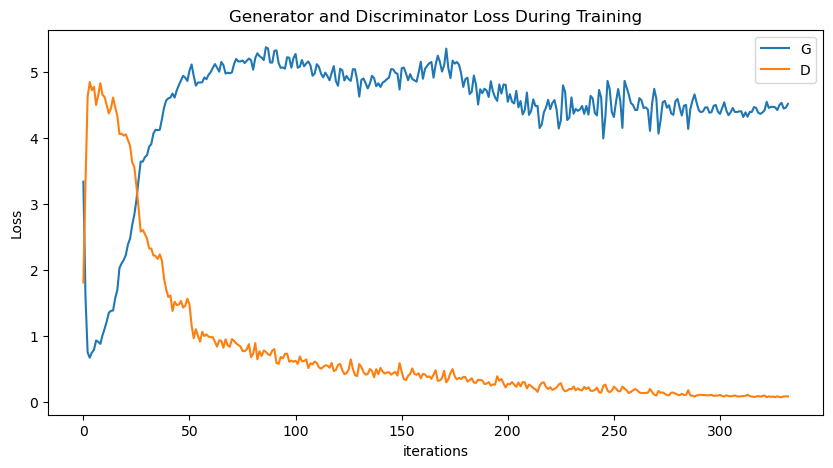

In [96]:
# Loss vs training iteration.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Ideally the D and G losses should begin to converge on some permenant number

In [32]:
#Visualizing the real and fake scores. 
# plt.plot(real_scores, '-')
# plt.plot(fake_scores, '-')
# plt.xlabel('epoch')
# plt.ylabel('score')
# plt.legend(['Real Score', 'Fake score'])
# plt.title('Scores');

In [49]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

C:\Users\Gaurav\Documents\Shaurya_project\gans_training.avi

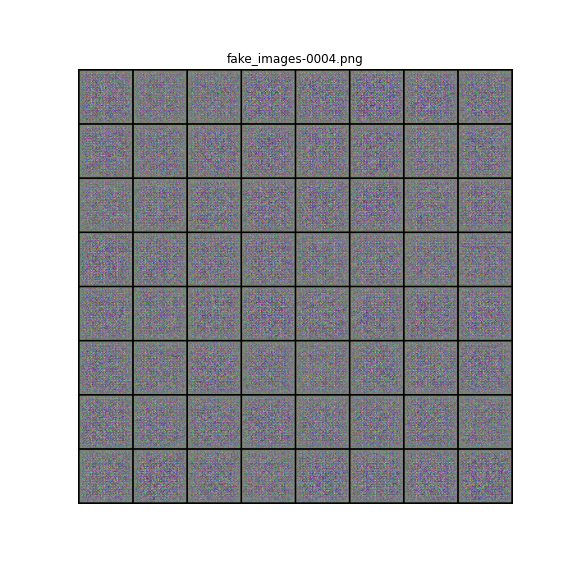

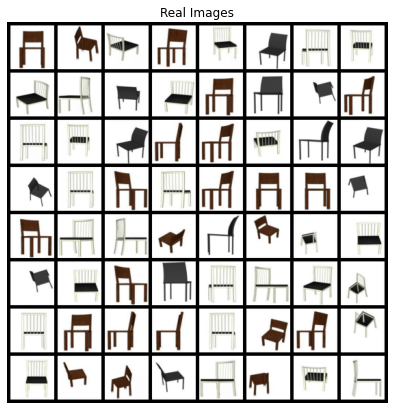

In [35]:
# comparing hte real and fake images: 

# Grab a batch of real images from the training data
real_batch = next(iter(train_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
Image(os.path.join(sample_dir, 'fake_images-0004.png'))